# Econ 8107 Assignment 1 - Problem 3

Author: Yuxuan Zhao

Date: Feb 1st, 2025


In [7]:
import numpy as np
import matplotlib.pyplot as plt

# Primitives
beta = 0.8
pi = np.array([0.5, 0.5])
Y = np.array([1.0, 0.5])

def u(c):
    return np.sqrt(np.maximum(c, 0.0))


## Question a - A grid for v


Since the continuation value for agent A is bounded between receiving zero consumption forever and receiving the entire aggregate endowment forever, we can bound $v$ by
$$
V_{\min}=\frac{\mathbb E[u(0)]}{1-\beta}=0,
\qquad
V_{\max}=\frac{\mathbb E[u(Y)]}{1-\beta}.
$$

Here $S=\{s_1,s_2\}$, $\pi(s_1)=\pi(s_2)=\tfrac12$, $Y(s_1)=1$, $Y(s_2)=\tfrac12$, and $u(c)=\sqrt{c}$. Thus
$$
\mathbb E[u(Y)]
=\tfrac12\sqrt{Y(s_1)}+\tfrac12\sqrt{Y(s_2)}
=\tfrac12\sqrt{1}+\tfrac12\sqrt{\tfrac12}
=\tfrac12+\frac{1}{2\sqrt2}
\approx 0.853553.
$$
With $\beta=0.8$,
$$
V_{\max}=\frac{0.853553}{1-0.8}=\frac{0.853553}{0.2}\approx 4.267767.
$$

Therefore, a convenient uniform grid is
$$
v \in [V_{\min},V_{\max}] = [0,\;4.267767],
$$
e.g. $v_j = V_{\min} + \frac{j-1}{N_v-1}(V_{\max}-V_{\min})$ for $j=1,\dots,N_v$.


In [8]:
# Bounds for promised value v
E_uY = pi @ u(Y)                 # E[u(Y)]
Vmin = 0.0                       # E[u(0)]/(1-beta) = 0
Vmax = E_uY / (1.0 - beta)

print("E[u(Y)] =", E_uY)
print("Vmin =", Vmin)
print("Vmax =", Vmax)

# Construct a uniform grid for v
Nv = 20                          # change as needed
vgrid = np.linspace(Vmin, Vmax, Nv)

print("vgrid =", vgrid)

E[u(Y)] = 0.8535533905932737
Vmin = 0.0
Vmax = 4.26776695296637
vgrid = [0.         0.22461931 0.44923863 0.67385794 0.89847725 1.12309657
 1.34771588 1.57233519 1.79695451 2.02157382 2.24619313 2.47081245
 2.69543176 2.92005107 3.14467039 3.3692897  3.59390901 3.81852833
 4.04314764 4.26776695]


## Question b - Value function iteration


We are given a current guess $P_i(v)$ on a grid $v \in vgrid$. For each promised value $v$, we compute the Bellman update
$$
P_{i+1}(v)=\max_{\{c(s),\,w(s)\in[\underline V,\overline V]\}_{s\in S}}
\sum_{s\in S}\pi(s)\Big(u(Y(s)-c(s))+\beta P_i(w(s))\Big)
$$
subject to the promise-keeping constraint
$$
v \le \sum_{s\in S}\pi(s)\Big(u(c(s))+\beta w(s)\Big).
$$
 
In maximum, we know the promise-keeping constraint holds with equality, so we rewrite it as
$$
v = \sum_{s\in\{s_1,s_2\}}\pi(s)\Big(u(c(s))+\beta w(s)\Big).
$$
With $(c_1,w_1,w_2)$, we can solve for $u(c_2)$:
$$
u(c_2)=2v-u(c_1)-\beta(w_1+w_2).
$$
Which gives:
$$
c_2=\Big(2v-\sqrt{c_1}-\beta(w_1+w_2)\Big)^2.
$$

**Feasibility conditions**:
- $0 \le c_1 \le Y(s_1)$ and $0 \le c_2 \le Y(s_2)$ 
- $2v-\sqrt{c_1}-\beta(w_1+w_2) \ge 0$



### Brute-force VFI algorithm 

**Grids**:
- Construct a grid for $c_1$ on $[0,Y(s_1)]$, e.g. 20 points: $c1grid$.
- Use the promised-value grid $vgrid$ also as the grid for continuation promises: $w_1,w_2 \in vgrid$.

**Outer iteration** (value function iteration):
1. Start from an initial guess $P_0(v)$ on $vgrid$ (e.g. all zeros).
2. For iteration $i=0,1,2,\dots$:
   - For each $v\in vgrid$, solve the inner maximization by brute force:
     - Loop over all $c_1\in c1grid$.
     - Loop over all $w_1\in vgrid$ and $w_2\in vgrid$.
     - Compute $c_2$ from the equality formula above.
     - If infeasible, skip this triple.
     - Otherwise evaluate the objective
       $$
       \text{Obj}(v;c_1,c_2,w_1,w_2)
       =\sum_{j\in\{1,2\}}\pi_j\Big(u(Y_j-c_j)+\beta P_i(w_j)\Big).
       $$
     - Take the maximum over all feasible triples and set
       $$
       P_{i+1}(v)=\max \text{Obj}(v;c_1,c_2,w_1,w_2).
       $$
     - Record the argmax policy if desired: $c_1(v),c_2(v),w_1(v),w_2(v)$.
   - Convergence check: compute the sup norm distance
     $$
     \|P_{i+1}-P_i\|_\infty = \max_{v\in vgrid}\big|P_{i+1}(v)-P_i(v)\big|.
     $$
     Stop if this is below a tolerance (e.g. $10^{-8}$); otherwise set $P_i\leftarrow P_{i+1}$ and repeat.



In [9]:
# --- VFI ---

# utility inverse for u(c)=sqrt(c)
def u_inv(x):
    return x * x

# Grid for c(s1) from 0 to Y(s1), ~20 points as suggested
Nc1 = 20
c1grid = np.linspace(0.0, Y[0], Nc1)

# VFI settings
tolp = 1e-8
iter_max = 5000

# initial guess P0(v) on vgrid
P = np.zeros_like(vgrid)

# optional: store policies
pol_c1 = np.full_like(vgrid, np.nan)
pol_c2 = np.full_like(vgrid, np.nan)
pol_w1 = np.full_like(vgrid, np.nan)
pol_w2 = np.full_like(vgrid, np.nan)

for t_idx in range(iter_max):
    P_new = np.empty_like(P)

    for v_idx, v in enumerate(vgrid):
        best_val = -np.inf
        best_tuple = None

        # brute-force over (c1, w1, w2), then solve for c2 from promise-keeping equality
        for c1 in c1grid:
            uc1 = u(c1)

            for w1_idx, w1 in enumerate(vgrid):
                

                for w2_idx, w2 in enumerate(vgrid):
                    # promise-keeping equality:
                    # v = sum_s pi(s) [u(c(s)) + beta w(s)]
                    # => u(c2) = (v - pi1(u(c1)+beta w1) - pi2 beta w2)/pi2
                    rhs = (v - pi[0] * (uc1 + beta * w1) - pi[1] * beta * w2) / pi[1]

                    # feasibility: u(c2) must be >= 0
                    if rhs < 0.0:
                        continue

                    c2 = u_inv(rhs)

                    # feasibility: 0 <= c2 <= Y2 and B consumption nonnegative
                    if c2 < 0.0 or c2 > Y[1]:
                        continue
                    

                    # objective:
                    val = (
                        pi[0] * (u(Y[0] - c1) + beta *  P[w1_idx])
                        + pi[1] * (u(Y[1] - c2) + beta * P[w2_idx])
                    )

                    if val > best_val:
                        best_val = val
                        best_tuple = (c1, c2, w1, w2)

        P_new[v_idx] = best_val
        if best_tuple is not None:
            pol_c1[v_idx], pol_c2[v_idx], pol_w1[v_idx], pol_w2[v_idx] = best_tuple
        else:
            # If infeasible due to coarse grids (rare), assign very low value
            P_new[v_idx] = -1e18

    diff = np.max(np.abs(P_new - P))
    P = P_new

    if diff < tolp:
        print(f"Converged in {t_idx+1} iterations; sup-norm diff = {diff:.2e}")
        break
else:
    print("Warning: VFI did not converge within maximum iterations.")

print("\nP(v) =", P)
print("\nPolicies:")
print("c1(v) =", pol_c1)
print("c2(v) =", pol_c2)
print("w1(v) =", pol_w1)
print("w2(v) =", pol_w2)



Converged in 83 iterations; sup-norm diff = 9.65e-09

P(v) = [ 4.26776691e+00  4.25343834e+00  4.22594816e+00  4.19845797e+00
  4.17096778e+00  4.11349593e+00  4.04911801e+00  3.96443669e+00
  3.86873630e+00  3.75762146e+00  3.62796047e+00  3.47816845e+00
  3.30692259e+00  3.11228997e+00  2.88401511e+00  2.61913122e+00
  2.29727674e+00  1.90463272e+00  1.36610788e+00 -1.00000000e+18]

Policies:
c1(v) = [0.         0.         0.05263158 0.         0.05263158 0.05263158
 0.10526316 0.15789474 0.15789474 0.21052632 0.26315789 0.31578947
 0.42105263 0.47368421 0.52631579 0.63157895 0.68421053 0.78947368
 0.89473684        nan]
c2(v) = [0.         0.00807261 0.01689354 0.00807261 0.01689354 0.0483221
 0.04607184 0.05362669 0.10331216 0.12235868 0.14860106 0.18179435
 0.18428735 0.23018235 0.28344114 0.30580509 0.37258012 0.40817789
 0.45071586        nan]
w1(v) = [0.         0.22461931 0.22461931 0.67385794 0.89847725 1.12309657
 1.34771588 1.57233519 1.79695451 2.02157382 2.24619313 2.4708

In this model, the upper bound $V_{\max}$ corresponds to giving agent A the entire endowment in every state, so the planner leaves agent B with zero consumption. Which implies that at the endpoint $v=V_{\max}$, we can only get a corner solution.

When this happens, the algorithm fails to find any feasible candidate at $v=V_{\max}$ and returns a very negative placeholder value (e.g., $-10^{18}$). This spurious infeasibility distorts the plot of $P(v)$ by blowing up the vertical scale.

Therefore, when plotting, it is best to avoid the endpoint $V_{\max}$—for example, by dropping the last grid point.


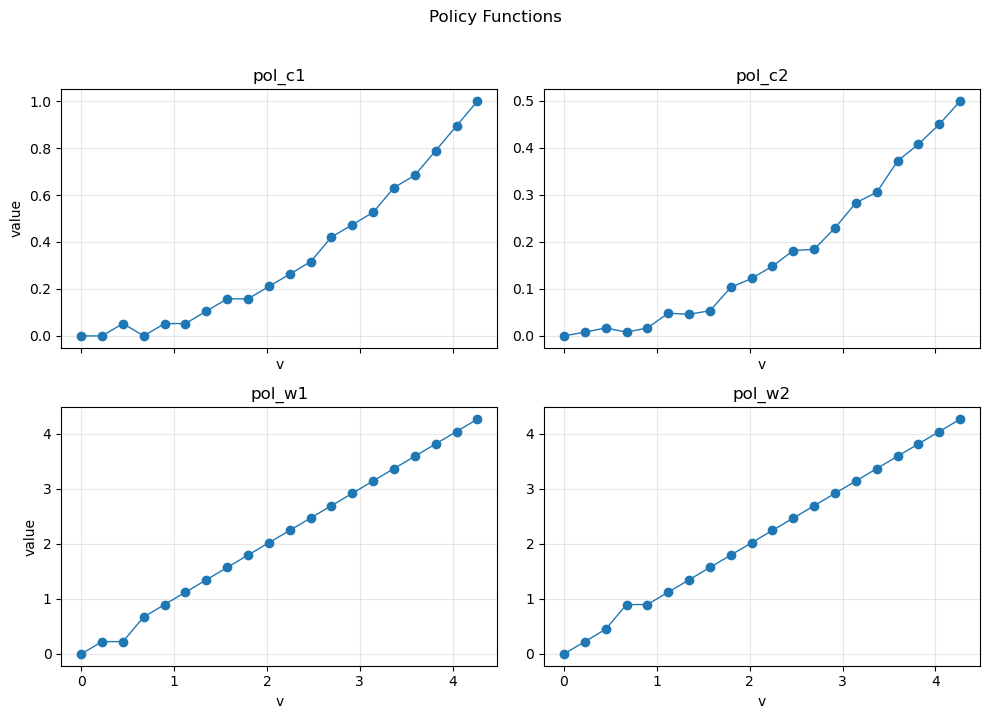

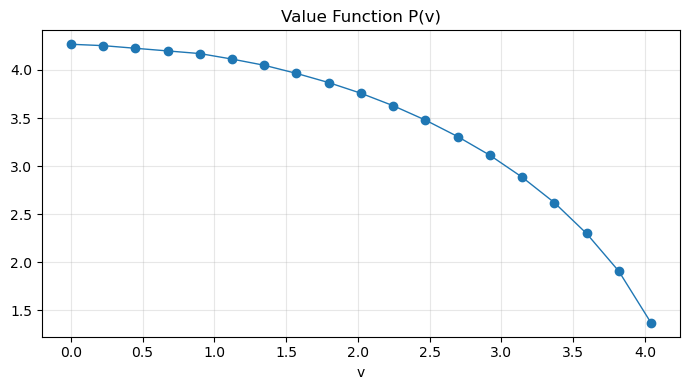

In [12]:
# ---- 2x2 panel for policy functions ----
fig, axes = plt.subplots(2, 2, figsize=(10, 7), sharex=True)

panels = [
    ("pol_c1", pol_c1, axes[0, 0]),
    ("pol_c2", pol_c2, axes[0, 1]),
    ("pol_w1", pol_w1, axes[1, 0]),
    ("pol_w2", pol_w2, axes[1, 1]),
]

for title, y, ax in panels:
    ax.plot(vgrid, y, marker="o", linewidth=1)
    ax.set_title(title)
    ax.set_xlabel("v")
    ax.grid(True, alpha=0.3)

# Make y-labels a bit cleaner
axes[0, 0].set_ylabel("value")
axes[1, 0].set_ylabel("value")

fig.suptitle("Policy Functions", y=1.02)
fig.tight_layout()
plt.show()

# ---- Single plot for value function ----
# drop the last point to avoid distortion from corner solution
vgrid_plt = vgrid[:-1]
P_plt = P[:-1]
plt.figure(figsize=(7, 4))
plt.plot(vgrid_plt, P_plt, marker="o", linewidth=1)
plt.title("Value Function P(v)")
plt.xlabel("v")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


## Question c: A check

Social planner’s problem with multiplier $\lambda$:
$$
\max_{\{c_A(s),c_B(s)\}_{s\in S}} \lambda \sum_{t=0}^{\infty}\beta^t \sum_{s\in S}\pi(s)\Big[u\big(c_A(s)\big)\Big] +  \sum_{t=0}^{\infty}\beta^t \sum_{s\in S}\pi(s)\Big[u\big(c_B(s)\big)\Big] \\
\Longleftrightarrow
\max_{\{c_A(s)\}_{s\in S}} \sum_{t=0}^{\infty}\beta^t \sum_{s\in S}\pi(s)\Big[\lambda u\big(c_A(s)\big)+ u\big(c_B(s)\big)\Big]
$$

subject to feasibility for all $s$:
$$
c_A(s)+c_B(s)\leq Y(s).
$$

Because states are i.i.d. and there is no intertemporal state variable, we can rewrite the problem as a *static* maximization in each state $s$:

$$
\max_{0\le c \le Y(s)}\ u\big(Y(s)-c\big)+\lambda u(c).
$$


For an interior solution, the first-order condition is

$$
\lambda u'(c)= u'\big(Y-c\big)
$$

With $u(c)=\sqrt{c}$ we have $u'(c)=\frac{1}{2\sqrt{c}}$. Substituting into the FOC gives

$$
\lambda \frac{1}{2\sqrt{c}}= \frac{1}{2\sqrt{Y-c}}
\quad\Longleftrightarrow\quad
2\sqrt{c}\lambda=2\sqrt{Y-c}.
$$

Squaring both sides:
$$
(Y - c) = \lambda^2 c 
\quad\Longleftrightarrow\quad
c=\frac{\lambda^2}{1+\lambda^2}Y.
$$

Thus, for each state $s$,
$$
c_A(s;\lambda)=\frac{\lambda^2}{1+\lambda^2}Y(s),
\qquad
c_B(s;\lambda)=Y(s)-c_A(s;\lambda)=\frac{1}{1+\lambda^2}Y(s).
$$

Then we can calculate the associated lifetime values for A and B are

$$
v(\lambda)=\sum_{t=0}^{\infty}\beta^t\,\mathbb E\big[u(c_A(s;\lambda))\big]
=\frac{\mathbb E\big[u(c_A(s;\lambda))\big]}{1-\beta},
$$

$$
P(\lambda)=\sum_{t=0}^{\infty}\beta^t\,\mathbb E\big[u(c_B(s;\lambda))\big]
=\frac{\mathbb E\big[u(c_B(s;\lambda))\big]}{1-\beta}.
$$

Using $u(c)=\sqrt{c}$ and the formulas above:

$$
u\big(c_A(s;\lambda)\big)=\sqrt{\frac{\lambda^2}{1+\lambda^2}Y(s)}
=\frac{\lambda}{\sqrt{1+\lambda^2}}\sqrt{Y(s)},
$$

$$
u\big(c_B(s;\lambda)\big)=\sqrt{\frac{1}{1+\lambda^2}Y(s)}
=\frac{1}{\sqrt{1+\lambda^2}}\sqrt{Y(s)}.
$$

Therefore, letting
$$
K \equiv \frac{\mathbb E[\sqrt{Y(s)}]}{1-\beta},
$$
we obtain compact expressions
$$
v(\lambda)=K\cdot \frac{\lambda}{\sqrt{1+\lambda^2}},
\qquad
P(\lambda)=K\cdot \frac{1}{\sqrt{1+\lambda^2}}.
$$

Eliminating $\lambda$ yields the closed-form frontier:
$$
\left(\frac{v}{K}\right)^2+\left(\frac{P}{K}\right)^2=1
\quad\Longleftrightarrow\quad
P(v)=\sqrt{K^2-v^2},\qquad v\in[0,K].
$$

To check part (b), compute $(v(\lambda),P(\lambda))$ for a grid of $\lambda$ and overlay it with the numerical $P(v)$ from VFI (dropping the endpoint $v=K$ if it is numerically problematic).

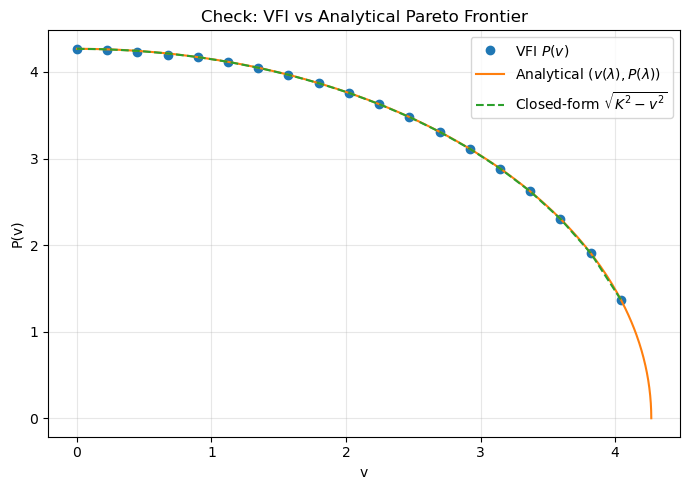

max |P_VFI(v) - sqrt(K^2 - v^2)| on plotted points = 0.018102325640865224


In [ ]:
# --- check ---

# K = E[sqrt(Y)]/(1-beta)
K = (pi @ np.sqrt(Y)) / (1.0 - beta)

# grid for lambda (avoid exactly 0 or infinity)
lam_grid = np.logspace(-4, 4, 500)

v_lam = K * (lam_grid / np.sqrt(1.0 + lam_grid**2))
P_lam = K * (1.0 / np.sqrt(1.0 + lam_grid**2))

# optional: also compute closed-form P(v) on the vgrid
# (drop last point if you dropped Vmax in plotting)
v_plt = vgrid[:-1]
P_plt = P[:-1]

P_closed = np.sqrt(np.maximum(K**2 - v_plt**2, 0.0))

plt.figure(figsize=(7, 5))
plt.plot(v_plt, P_plt, "o", label="VFI $P(v)$")
plt.plot(v_lam, P_lam, "-", linewidth=1.5, label="Analytical $(v(\\lambda),P(\\lambda))$")
plt.plot(v_plt, P_closed, "--", linewidth=1.5, label="Closed-form $\\sqrt{K^2-v^2}$")
plt.xlabel("v")
plt.ylabel("P(v)")
plt.title("Check: VFI vs Analytical Pareto Frontier")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# print a simple error metric on the plotted grid
err = np.max(np.abs(P_plt - P_closed))
print("max |P_VFI(v) - sqrt(K^2 - v^2)| on plotted points =", err)


## Appendix: Numerical check code snippet
 Check whether the vgrid Vmax will cause endpoint issues in numerical value function iteration

In [11]:
eps = 1e-3
vgrid = np.linspace(Vmin, Vmax-eps, Nv)


# --- VFI ---


# Grid for c(s1) from 0 to Y(s1), ~20 points as suggested
Nc1 = 20
c1grid = np.linspace(0.0, Y[0], Nc1)

# VFI settings
tolp = 1e-8
iter_max = 5000

# initial guess P0(v) on vgrid
P = np.zeros_like(vgrid)

# optional: store policies
pol_c1 = np.full_like(vgrid, np.nan)
pol_c2 = np.full_like(vgrid, np.nan)
pol_w1 = np.full_like(vgrid, np.nan)
pol_w2 = np.full_like(vgrid, np.nan)

for t_idx in range(iter_max):
    P_new = np.empty_like(P)

    for v_idx, v in enumerate(vgrid):
        best_val = -np.inf
        best_tuple = None

        # brute-force over (c1, w1, w2), then solve for c2 from promise-keeping equality
        for c1 in c1grid:
            uc1 = u(c1)

            for w1_idx, w1 in enumerate(vgrid):
                

                for w2_idx, w2 in enumerate(vgrid):
                    # promise-keeping equality:
                    # v = sum_s pi(s) [u(c(s)) + beta w(s)]
                    # => u(c2) = (v - pi1(u(c1)+beta w1) - pi2 beta w2)/pi2
                    rhs = (v - pi[0] * (uc1 + beta * w1) - pi[1] * beta * w2) / pi[1]

                    # feasibility: u(c2) must be >= 0
                    if rhs < 0.0:
                        continue

                    c2 = u_inv(rhs)

                    # feasibility: 0 <= c2 <= Y2 and B consumption nonnegative
                    if c2 < 0.0 or c2 > Y[1]:
                        continue
                    

                    # objective:
                    val = (
                        pi[0] * (u(Y[0] - c1) + beta *  P[w1_idx])
                        + pi[1] * (u(Y[1] - c2) + beta * P[w2_idx])
                    )

                    if val > best_val:
                        best_val = val
                        best_tuple = (c1, c2, w1, w2)

        P_new[v_idx] = best_val
        if best_tuple is not None:
            pol_c1[v_idx], pol_c2[v_idx], pol_w1[v_idx], pol_w2[v_idx] = best_tuple
        else:
            # If infeasible due to coarse grids (rare), assign very low value
            P_new[v_idx] = -1e18

    diff = np.max(np.abs(P_new - P))
    P = P_new

    if diff < tolp:
        print(f"Converged in {t_idx+1} iterations; sup-norm diff = {diff:.2e}")
        break
else:
    print("Warning: VFI did not converge within maximum iterations.")

print("\nP(v) =", P)
print("\nPolicies:")
print("c1(v) =", pol_c1)
print("c2(v) =", pol_c2)
print("w1(v) =", pol_w1)
print("w2(v) =", pol_w2)

Converged in 83 iterations; sup-norm diff = 9.65e-09

P(v) = [4.26776691 4.25344509 4.22596577 4.19848645 4.17100713 4.11358199
 4.04921858 3.96456434 3.8689511  3.75789099 3.6283026  3.47860586
 3.3074049  3.1129216  2.88485756 2.62012119 2.29871517 1.90651631
 1.36896466 0.05945195]

Policies:
c1(v) = [0.         0.         0.05263158 0.         0.05263158 0.05263158
 0.10526316 0.15789474 0.15789474 0.21052632 0.26315789 0.31578947
 0.42105263 0.47368421 0.52631579 0.63157895 0.68421053 0.78947368
 0.89473684 1.        ]
c2(v) = [0.         0.00806883 0.01687166 0.00806883 0.01687166 0.04827584
 0.04601763 0.05355846 0.10320392 0.12222616 0.14843879 0.18159693
 0.18407051 0.22991981 0.2831274  0.30545593 0.37216902 0.40772071
 0.45020719 0.49943447]
w1(v) = [0.         0.22456668 0.22456668 0.67370005 0.89826673 1.12283341
 1.34740009 1.57196677 1.79653345 2.02110014 2.24566682 2.4702335
 2.69480018 2.91936686 3.14393354 3.36850023 3.59306691 3.81763359
 4.04220027 4.26676695]
w2(v)